## Chapter - 5 code

In [38]:
%load_ext autoreload
%autoreload 2

In [96]:
import warnings
warnings.filterwarnings('ignore')

### ML-Ensemble

In [10]:
#Uncomment the following line to install mlens
#pip install mlens

#### Data setup

In [11]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from sklearn.datasets import make_moons

In [12]:
seed = 42

In [13]:
np.random.seed(seed)

In [14]:
X, y = make_moons(n_samples=10000,noise=0.4, random_state=seed)

In [15]:
#Split it in train-test
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [17]:
from mlens.ensemble import SuperLearner
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# --- Build ---
# Passing a scoring function will create cv scores during fitting
# the scorer should be a simple function accepting to vectors and returning a scalar
ensemble = SuperLearner(scorer=accuracy_score, random_state=seed, verbose=2)

# Build the first layer
ensemble.add([RandomForestClassifier(random_state=seed), SVC(random_state=seed)])

# Attach the final meta estimator
ensemble.add_meta(LogisticRegression())

# --- Use ---

# Fit ensemble
ensemble.fit(X_train, y_train)

# Predict
preds = ensemble.predict(X_test)


Fitting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:00

Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:00


In [18]:
print("Fit data:\n%r" % ensemble.data)

Fit data:
                                   score-m  score-s  ft-m  ft-s  pt-m  pt-s
layer-1  randomforestclassifier       0.85     0.00  0.51  0.00  0.06  0.00
layer-1  svc                          0.86     0.00  0.16  0.01  0.06  0.00



In [19]:
print("Prediction score: %.3f" % accuracy_score(y_test, preds))

Prediction score: 0.874


#### Adding multiple layers

In [20]:
# --- Build ---
# Passing a scoring function will create cv scores during fitting
# the scorer should be a simple function accepting to vectors and returning a scalar
ensemble = SuperLearner(scorer=accuracy_score, random_state=seed, verbose=2)

# Build the first layer
ensemble.add([RandomForestClassifier(random_state=seed), LogisticRegression()])

# Build the 2nd layer
ensemble.add([LogisticRegression(), SVC()])

# Attach the final meta estimator
ensemble.add_meta(SVC())

# --- Use ---

# Fit ensemble
ensemble.fit(X_train, y_train)

# Predict
preds = ensemble.predict(X_test)


Fitting 3 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Processing layer-3             done | 00:00:00
Fit complete                        | 00:00:02

Predicting 3 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Processing layer-3             done | 00:00:00
Predict complete                    | 00:00:00


In [21]:
print("Fit data:\n%r" % ensemble.data)

Fit data:
                                   score-m  score-s  ft-m  ft-s  pt-m  pt-s
layer-1  logisticregression           0.83     0.00  0.14  0.00  0.00  0.00
layer-1  randomforestclassifier       0.85     0.00  0.60  0.00  0.06  0.00
layer-2  logisticregression           0.85     0.00  0.02  0.00  0.00  0.00
layer-2  svc                          0.85     0.00  0.13  0.01  0.09  0.00



In [22]:
# Predict
preds = ensemble.predict(X_test)


Predicting 3 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Processing layer-3             done | 00:00:00
Predict complete                    | 00:00:00


In [23]:
# Score
print("Prediction score: %.3f" % accuracy_score(y_test, preds))

Prediction score: 0.851


In [24]:
from mlens.metrics import make_scorer
accuracy_scorer = make_scorer(accuracy_score, greater_is_better=True)

In [25]:
ensemble = SuperLearner(scorer=accuracy_scorer, random_state=seed, verbose=2)

# Build the first layer
ensemble.add([RandomForestClassifier(random_state=seed), SVC()])

# Attach the final meta estimator
ensemble.add_meta(LogisticRegression())

# --- Use ---

# Fit ensemble
ensemble.fit(X_train, y_train)

# Predict
preds = ensemble.predict(X_test)


Fitting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:01

Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:00


In [26]:
print("Fit data:\n%r" % ensemble.data)

Fit data:
                                   ft-m  ft-s  pt-m  pt-s
layer-1  randomforestclassifier    0.54  0.00  0.06  0.00
layer-1  svc                       0.19  0.04  0.06  0.00



In [27]:
print("Prediction score: %.3f" % accuracy_score(y_test, preds))

Prediction score: 0.874


#### Ensemble model selectionm

In [28]:
from mlens.model_selection import Evaluator
from mlens.ensemble import SequentialEnsemble
from mlens.metrics import make_scorer
from scipy.stats import uniform, randint

In [29]:
# Set up two competing ensemble bases as preprocessing transformers:
# one stacked ensemble base with proba and one without
base_learners = [RandomForestClassifier(random_state=seed),
                 SVC(probability=True)]

proba_transformer = SequentialEnsemble(
                        model_selection=True, random_state=seed).add(
                            'blend', base_learners, proba=True)
class_transformer = SequentialEnsemble(
                        model_selection=True, random_state=seed).add(
                            'blend', base_learners, proba=False)

In [30]:
preprocessing = {'proba': [('layer-1', proba_transformer)],
                 'class': [('layer-1', class_transformer)]}

In [31]:
meta_learners = [SVC(random_state=seed), ('rf', RandomForestClassifier(random_state=seed))]

In [32]:
params = {'svc': {'C': uniform(0, 10)},
          'class.rf': {'max_depth': randint(2, 10)},
          'proba.rf': {'max_depth': randint(2, 10),
                            'max_features': uniform(0.5, 0.5)}
          }

In [33]:
scorer = make_scorer(accuracy_score)
evaluator = Evaluator(scorer=scorer, random_state=seed, cv=2)

evaluator.fit(X, y, meta_learners, params, preprocessing=preprocessing, n_iter=2)

In [34]:
print("Results:\n%s" % evaluator.results)

Results:
              test_score-m  test_score-s  train_score-m  train_score-s  fit_time-m  fit_time-s  pred_time-m  pred_time-s                                                params
class  rf            0.863         0.002          0.861          0.000       5.451       0.403        1.105        0.066                                      {'max_depth': 8}
class  svc           0.863         0.002          0.861          0.000       2.088       0.114        0.185        0.042                              {'C': 3.745401188473625}
proba  rf            0.861         0.001          0.873          0.005       7.165       0.007        0.900        0.074  {'max_depth': 5, 'max_features': 0.9753571532049581}
proba  svc           0.862         0.001          0.861          0.001       1.258       0.089        0.120        0.072                               {'C': 9.50714306409916}



In [35]:
from pandas import DataFrame

In [36]:
df = DataFrame(evaluator.results)

In [37]:
df

,test_score-m,test_score-s,train_score-m,train_score-s,fit_time-m,fit_time-s,pred_time-m,pred_time-s,params
class.rf,0.8628,0.0016,0.8606,0.0002,5.451228,0.403456,1.104740,0.065760,{'max_depth': 8}
class.svc,0.8628,0.0016,0.8606,0.0002,2.087886,0.113944,0.184946,0.041534,{'C': 3.745401188473625}
proba.rf,0.8611,0.0007,0.8734,0.0046,7.164795,0.007081,0.899773,0.073507,"{'max_depth': 5, 'max_features': 0.97535715320..."
proba.svc,0.8624,0.0006,0.8610,0.0010,1.258333,0.088611,0.119865,0.072385,{'C': 9.50714306409916}


### Dask

In [39]:
import dask

In [40]:
@dask.delayed
def inc(x):
    return x + 1

@dask.delayed
def double(x):
    return x + 2

@dask.delayed
def add(x, y):
    return x + y

In [41]:
data = [1, 2, 3, 4, 5]

output = []
for x in data:
    a = inc(x)
    b = double(x)
    c = add(a, b)
    output.append(c)

total = dask.delayed(sum)(output)

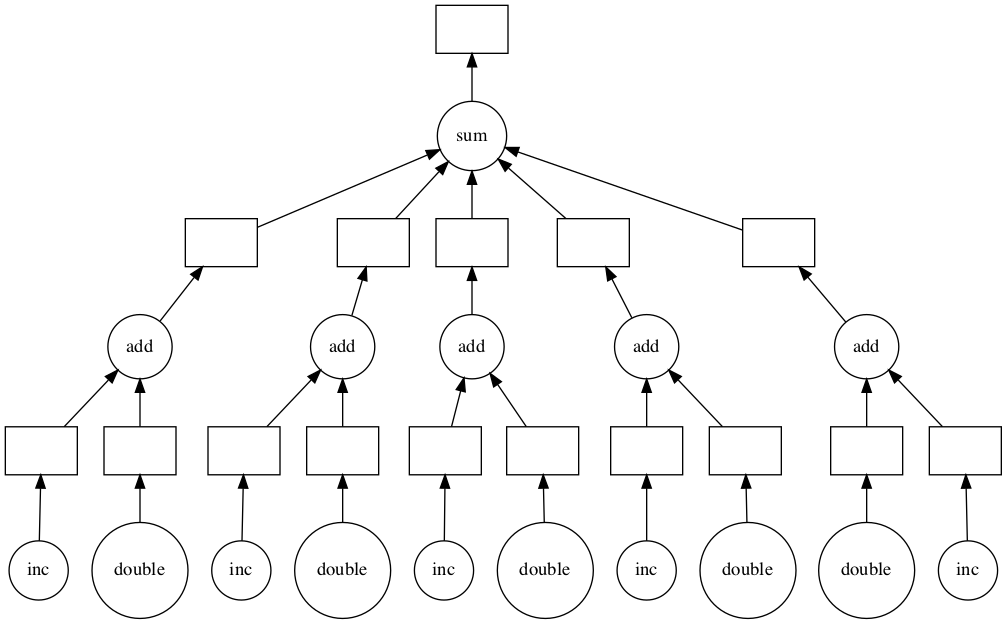

In [42]:
total.visualize()

In [43]:
total.compute()

45

In [44]:
import dask.array as da
x = da.ones((15, 15), chunks=(5, 5))

In [45]:
type(x)

dask.array.core.Array

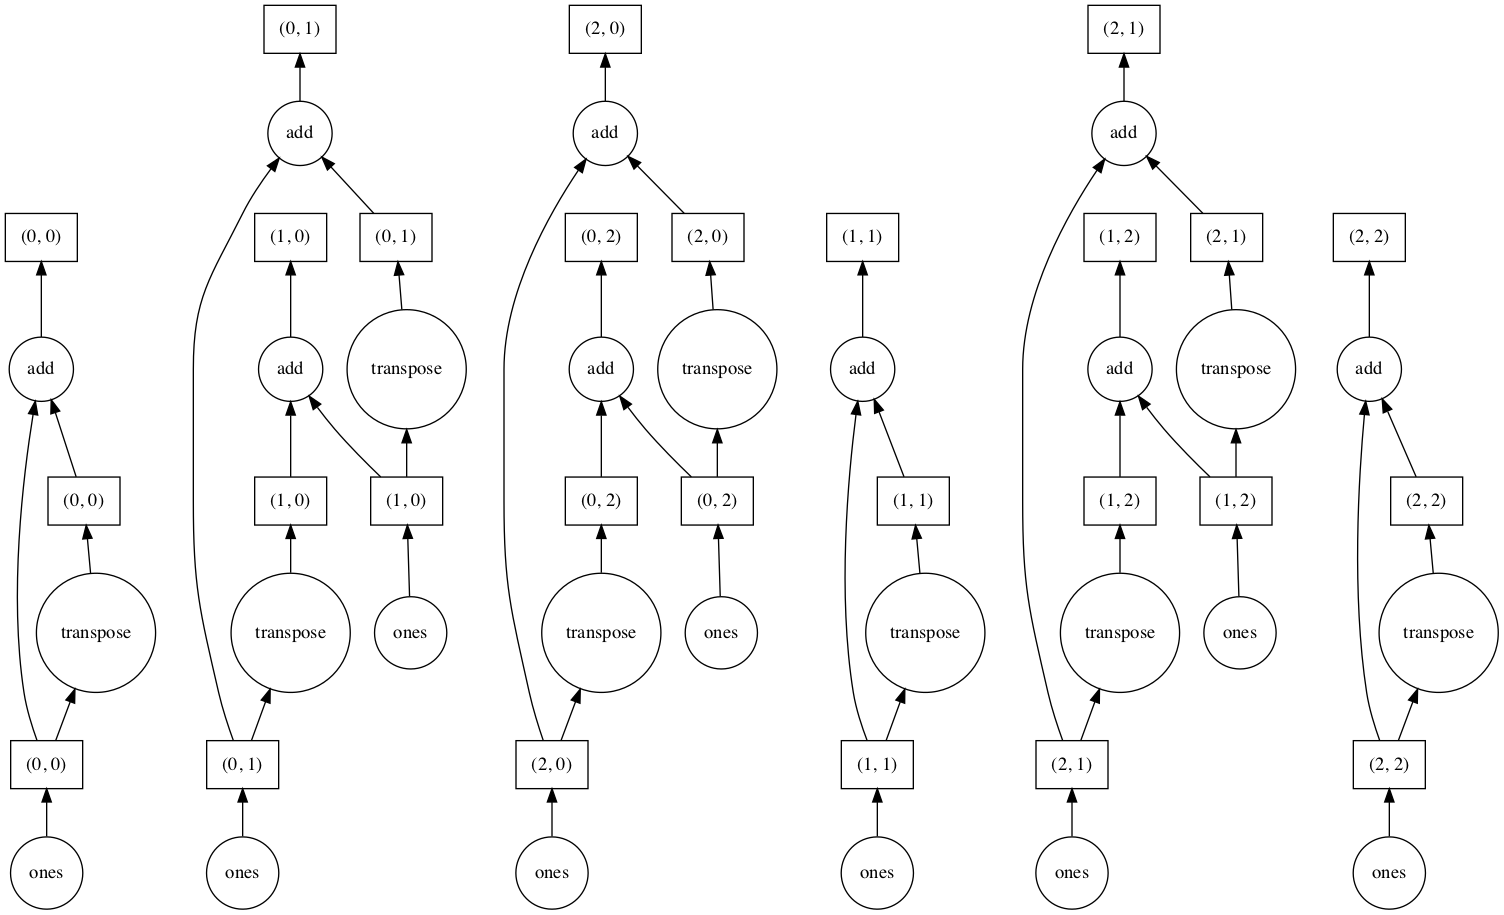

In [46]:
y = x + x.T
y.visualize()

In [47]:
y = x + x.T
y.compute()

array([[2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2.

#### LogisticRegression

In [48]:
from dask_glm.datasets import make_classification
from dask_ml.linear_model import LogisticRegression
from dask_ml.model_selection import train_test_split

In [49]:
X, y = make_classification()

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [51]:
lr = LogisticRegression()

In [52]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1.0, max_iter=100, multi_class='ovr',
                   n_jobs=1, penalty='l2', random_state=None, solver='admm',
                   solver_kwargs=None, tol=0.0001, verbose=0, warm_start=False)

In [53]:
lr.predict(X_test)

dask.array<gt, shape=(100,), dtype=bool, chunksize=(10,), chunktype=numpy.ndarray>

In [54]:
lr.predict_proba(X_test)

dask.array<truediv, shape=(100,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>

In [55]:
lr.score(X_test, y_test)

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

#### LR on cluster

In [56]:
from dask_ml.model_selection import GridSearchCV

In [57]:
parameters = {'penalty': ['l1', 'l2'], 'C': [0.5, 1, 2]}

In [58]:
lr = LogisticRegression(random_state=seed)

In [59]:
est = GridSearchCV(lr, param_grid=parameters)

In [60]:
est.fit(X_train,y_train)

GridSearchCV(cache_cv=True, cv=None, error_score='raise',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1.0, max_iter=100,
                                          multi_class='ovr', n_jobs=1,
                                          penalty='l2', random_state=42,
                                          solver='admm', solver_kwargs=None,
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid=True, n_jobs=-1,
             param_grid={'C': [0.5, 1, 2], 'penalty': ['l1', 'l2']}, refit=True,
             return_train_score=False, scheduler=None, scoring=None)

In [61]:
from dask.distributed import Client
client = Client()

In [62]:
import joblib
with joblib.parallel_backend('dask'):
    est.fit(X_train, y_train)

In [63]:
est.best_params_

{'C': 1, 'penalty': 'l2'}

### Dask-XGBoost

In [64]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:62106 Dashboard: http://127.0.0.1:62107/status,Cluster Workers: 4 Cores: 12 Memory: 17.18 GB


In [65]:
from dask_ml.datasets import make_classification

X, y = make_classification(n_samples=100000, n_features=20,
                           chunks=1000, n_informative=4,
                           random_state=0)
X

,Array,Chunk
Bytes,16.00 MB,160.00 kB
Shape,"(100000, 20)","(1000, 20)"
Count,100 Tasks,100 Chunks
Type,float64,numpy.ndarray


In [66]:
import dask
import xgboost
import dask_xgboost

In [67]:
params = {'objective': 'binary:logistic',
          'max_depth': 4, 'eta': 0.01, 'subsample': 0.5,
          'min_child_weight': 0.5}

In [68]:
bst = dask_xgboost.train(client, params, X_train, y_train, num_boost_round=10)

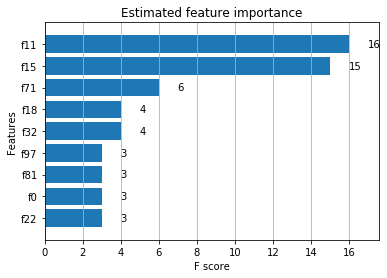

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt

ax = xgboost.plot_importance(bst, height=0.8, max_num_features=9)
ax.grid(False, axis="y")
ax.set_title('Estimated feature importance')
plt.show()

In [70]:
y_hat = dask_xgboost.predict(client, bst, X_test).persist()

In [72]:
y_hat

dask.array<_predict_part, shape=(100,), dtype=float32, chunksize=(10,), chunktype=numpy.ndarray>

### LightGBM with fit

In [73]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [74]:
X, y = make_classification(n_samples=10000, n_features=20,n_classes = 2,random_state = 42)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [76]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000, 20) (2000, 20) (8000,) (2000,)


In [77]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [78]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'verbose': 0
}

In [79]:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

[1]	valid_0's l2: 0.230734	valid_0's l1: 0.480237
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 0.213535	valid_0's l1: 0.461663
[3]	valid_0's l2: 0.198007	valid_0's l1: 0.444008
[4]	valid_0's l2: 0.184023	valid_0's l1: 0.427276
[5]	valid_0's l2: 0.17131	valid_0's l1: 0.411283
[6]	valid_0's l2: 0.159949	valid_0's l1: 0.396235
[7]	valid_0's l2: 0.149618	valid_0's l1: 0.381854
[8]	valid_0's l2: 0.1402	valid_0's l1: 0.368144
[9]	valid_0's l2: 0.13174	valid_0's l1: 0.355117
[10]	valid_0's l2: 0.124136	valid_0's l1: 0.342826
[11]	valid_0's l2: 0.117163	valid_0's l1: 0.331026
[12]	valid_0's l2: 0.110878	valid_0's l1: 0.319826
[13]	valid_0's l2: 0.105179	valid_0's l1: 0.309168
[14]	valid_0's l2: 0.100068	valid_0's l1: 0.299052
[15]	valid_0's l2: 0.0953521	valid_0's l1: 0.289409
[16]	valid_0's l2: 0.0912064	valid_0's l1: 0.280354
[17]	valid_0's l2: 0.0873719	valid_0's l1: 0.271689
[18]	valid_0's l2: 0.0839541	valid_0's l1: 0.263467
[19]	valid_0's l2: 0.0807741	va

In [80]:
gbm = lgb.LGBMClassifier(num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=20)

In [81]:
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=5)

[1]	valid_0's l1: 0.480237	valid_0's binary_logloss: 0.654587
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l1: 0.461663	valid_0's binary_logloss: 0.620027
[3]	valid_0's l1: 0.444008	valid_0's binary_logloss: 0.588584
[4]	valid_0's l1: 0.427276	valid_0's binary_logloss: 0.559966
[5]	valid_0's l1: 0.411283	valid_0's binary_logloss: 0.533604
[6]	valid_0's l1: 0.396235	valid_0's binary_logloss: 0.509672
[7]	valid_0's l1: 0.381854	valid_0's binary_logloss: 0.48752
[8]	valid_0's l1: 0.368144	valid_0's binary_logloss: 0.466944
[9]	valid_0's l1: 0.355117	valid_0's binary_logloss: 0.448058
[10]	valid_0's l1: 0.342826	valid_0's binary_logloss: 0.430692
[11]	valid_0's l1: 0.331026	valid_0's binary_logloss: 0.414384
[12]	valid_0's l1: 0.319826	valid_0's binary_logloss: 0.399309
[13]	valid_0's l1: 0.309168	valid_0's binary_logloss: 0.385288
[14]	valid_0's l1: 0.299052	valid_0's binary_logloss: 0.372348
[15]	valid_0's l1: 0.289409	valid_0's binary_logloss: 0.360136
[16]	

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=20, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

### LightGBM with train

In [82]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import numpy as np

The LightGBM Python module can load data from:

LibSVM (zero-based) / TSV / CSV / TXT format file
NumPy 2D array(s), pandas DataFrame, H2O DataTable’s Frame, SciPy sparse matrix
LightGBM binary file
The data is stored in a Dataset object.

In [83]:
n_features  = 20
data = np.random.rand(5000, 20)  # 5000 entities, each contains 20 features
label = np.random.randint(2, size=5000)  # binary target

In [84]:
X_trn, X_val, y_trn, y_val = train_test_split(data, label, test_size=0.30)

In [85]:
feature_name = ['feature_' + str(col) for col in range(n_features)]

In [86]:
train_data = lgb.Dataset(X_trn, label=y_trn,feature_name=feature_name, 
                         categorical_feature=[feature_name[-1]],free_raw_data=False)

In [87]:
train_data.feature_name

['feature_0',
 'feature_1',
 'feature_2',
 'feature_3',
 'feature_4',
 'feature_5',
 'feature_6',
 'feature_7',
 'feature_8',
 'feature_9',
 'feature_10',
 'feature_11',
 'feature_12',
 'feature_13',
 'feature_14',
 'feature_15',
 'feature_16',
 'feature_17',
 'feature_18',
 'feature_19']

In [88]:
validation_data = lgb.Dataset(X_val,label=y_val,reference=train_data)

LightGBM uses a dictionary to set Parameters.

In [89]:
param = {'num_leaves': 31, 'objective': 'binary'}

You can also specify multiple eval metrics:

In [90]:
param['metric'] = ['auc', 'binary_logloss']

Training a model requires a parameter list and data set:

In [91]:
num_round = 10
bst = lgb.train(param, train_data, num_round, valid_sets=[validation_data])

[1]	valid_0's auc: 0.527282	valid_0's binary_logloss: 0.692513
[2]	valid_0's auc: 0.5169	valid_0's binary_logloss: 0.693254
[3]	valid_0's auc: 0.504606	valid_0's binary_logloss: 0.694487
[4]	valid_0's auc: 0.510506	valid_0's binary_logloss: 0.694676
[5]	valid_0's auc: 0.510038	valid_0's binary_logloss: 0.695748
[6]	valid_0's auc: 0.514945	valid_0's binary_logloss: 0.695655
[7]	valid_0's auc: 0.519569	valid_0's binary_logloss: 0.695498
[8]	valid_0's auc: 0.521031	valid_0's binary_logloss: 0.695513
[9]	valid_0's auc: 0.519589	valid_0's binary_logloss: 0.695718
[10]	valid_0's auc: 0.516256	valid_0's binary_logloss: 0.696304


In [92]:
print('Feature importances:', list(bst.feature_importance()))

Feature importances: [19, 16, 18, 18, 18, 12, 12, 16, 9, 9, 25, 20, 16, 14, 14, 11, 16, 23, 14, 0]


In [93]:
data = np.random.rand(7, 20)
ypred = bst.predict(data)

In [106]:
#Converting probabilities in classes
for i in range(7): 
    if ypred[i]>=.5:       # setting threshold to .5 
       ypred[i]=1 
    else: 
       ypred[i]=0  

In [108]:
print(ypred)

[0. 0. 0. 1. 1. 0. 0.]
